C:\Users\loke_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


A01: Products of agriculture, hunting and related services
A02: Products of forestry, logging and related services
A03: Fish and other fishing products; aquaculture products; support services to fishing
B: Mining and quarrying
C10T12: Food products, beverages and tobacco products
C13T15: Textiles, wearing apparel and leather products
C16: Wood and of products of wood and cork, except furniture; articles of straw and plaiting materials
C17: Paper and paper products
C18: Printing and recording services
C19: Coke and refined petroleum products 
C20-21: Chemicals and chemical products AND Basic pharmaceutical products and pharmaceutical preparations
C22: Rubber and plastics products
C23: Other non-metallic mineral products
C24: Basic metals
C25: Fabricated metal products, except machinery and equipment
C26: Computer, electronic and optical products
C27: Electrical equipment
C28: Machinery and equipment n.e.c.
C29: Motor vehicles, trailers and semi-trailers
C30: Other transport equipment
C3

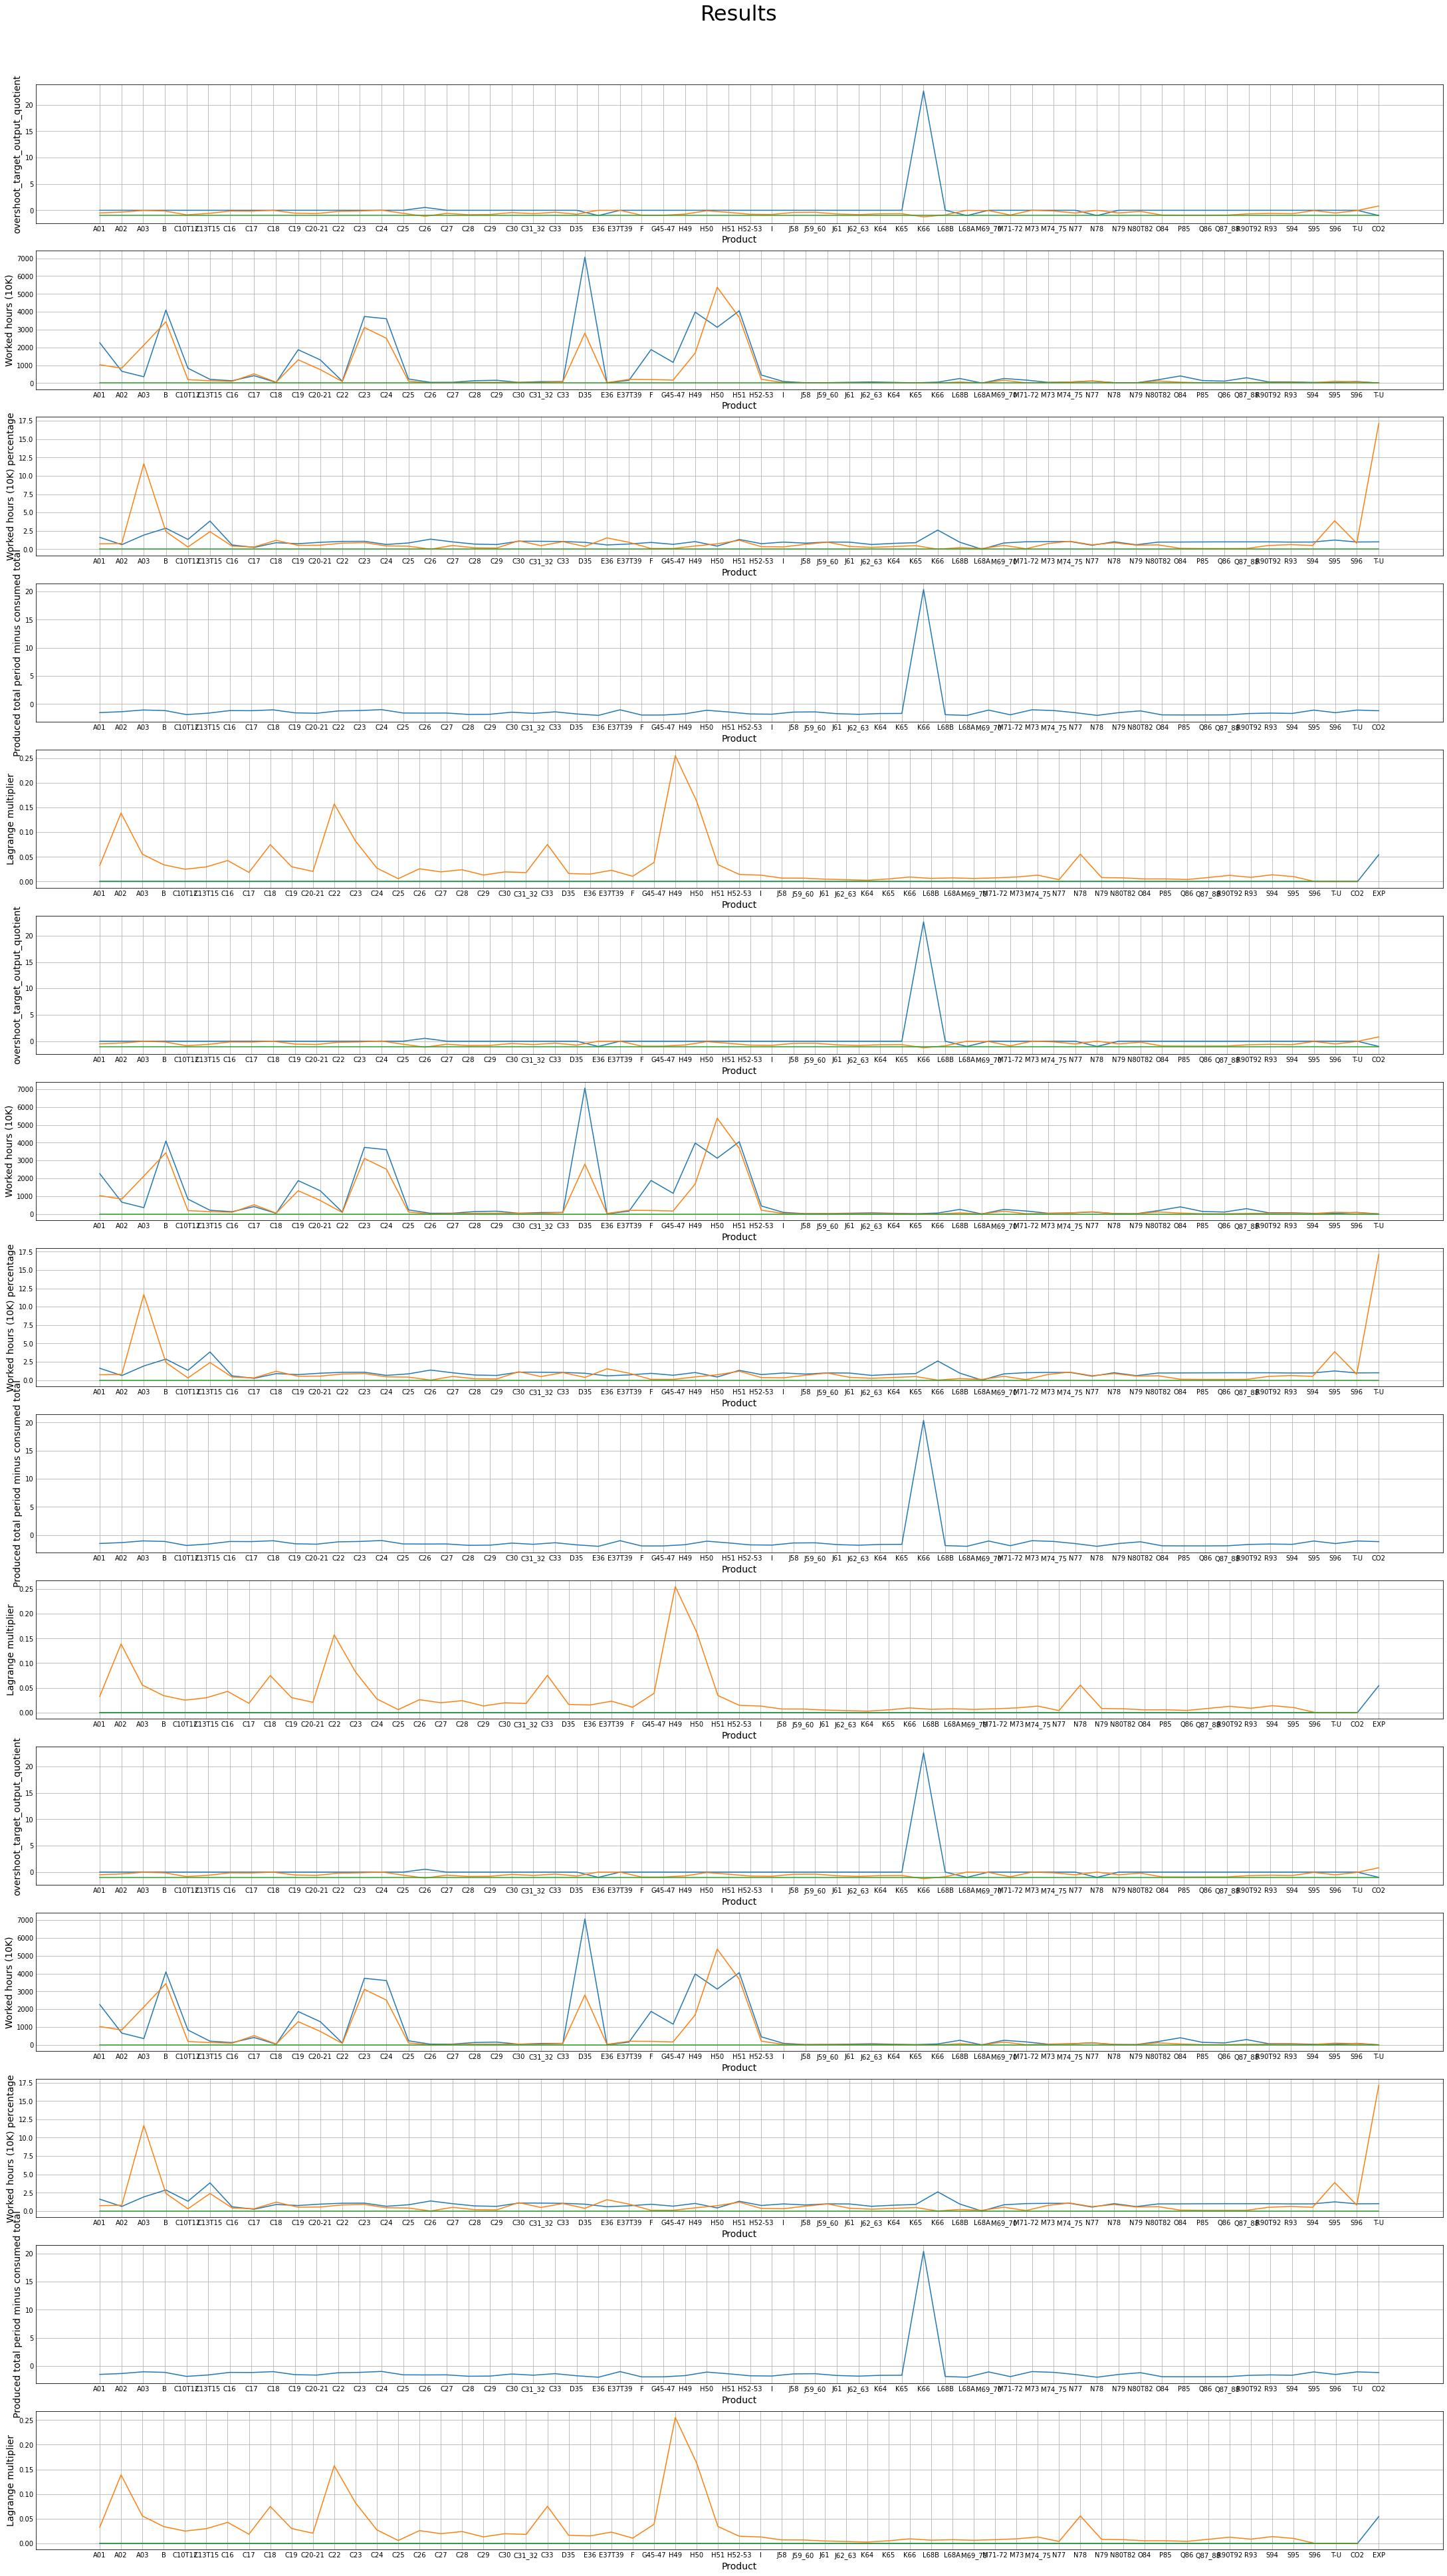

{'result_list': [array([2.26094951e+03, 6.58939855e+02, 3.51155184e+02, 4.09327478e+03,
         8.30745102e+02, 2.06039298e+02, 1.26760739e+02, 4.11529611e+02,
         3.44041836e+01, 1.86836856e+03, 1.30013887e+03, 1.04011657e+02,
         3.73453607e+03, 3.60629671e+03, 2.26898372e+02, 3.72752409e+01,
         4.16629058e+01, 1.32327194e+02, 1.54376527e+02, 3.69646252e+01,
         7.71108202e+01, 8.21911350e+01, 7.06553041e+03, 9.55013445e+00,
         1.53057840e+02, 1.87644478e+03, 1.16101339e+03, 3.97875300e+03,
         3.12932417e+03, 4.05178740e+03, 4.47752167e+02, 8.60234864e+01,
         1.57739424e+01, 2.24383371e+01, 4.03332954e+01, 5.97702366e+01,
         3.55630890e+01, 1.21531454e+01, 5.06315701e+01, 2.54614328e+02,
         0.00000000e+00, 2.54790857e+02, 1.65278192e+02, 3.91314370e+01,
         5.55938118e+01, 1.08839142e+02, 2.15235781e+01, 1.37911802e+01,
         1.85420991e+02, 3.96537221e+02, 1.39548781e+02, 1.06708545e+02,
         2.95677943e+02, 6.44778839e

In [1]:
from rhp_plan import plan
from pathlib import Path
import openpyxl
import numpy as np
from copy import deepcopy


xlsx_file = Path('nrio_sut_181108.xlsx')
main_sheet = openpyxl.load_workbook(xlsx_file).active
xlsx_file = Path('posternas_namn.xlsx')
shorthand_sheet = openpyxl.load_workbook(xlsx_file)['SUP10']

def zdivide(x, y):
    return np.divide(x, y, out=np.zeros_like(x), where=y!=0)

# Generates a 2D list of values from an xlsx file, reading left to right, top to bottom.
class Sheet:
    def __init__(self, sheet, left: int, top: int, right: int, bottom: int):
        result_sheet = []
        coordinates = []
        for row in sheet.iter_rows(min_row=left, min_col=top, max_row=right, max_col=bottom):
            data = []
            pos = []
            for cell in row:
                data.append(cell.value)
                pos.append(cell)

            result_sheet.append(data)
            coordinates.append(pos)

        self.result = result_sheet
        self.coordinates = coordinates

    @property
    def np_array(self):
        return np.array(self.result, dtype=np.float64)


class ProductionMatrix:
    def __init__(self, use_domestic: Sheet, use_imported: Sheet, supply: Sheet, other_variables: Sheet):
        self.use_domestic = use_domestic
        self.use_imported = use_imported
        self.supply = supply
        self.other_variables = other_variables

    @property
    def use_domestic_matrix(self):
        return np.matrix(np.concatenate([self.use_domestic.np_array, [[0] * len(self.use_domestic.np_array[0])]], axis=0)) # Add row at the end with zero values

    @property
    def use_imported_matrix(self):
        return np.matrix(np.concatenate([self.use_imported.np_array, [[0] * len(self.use_imported.np_array[0])]], axis=0))

    @property
    def supply_matrix(self):
        return np.matrix(np.concatenate([self.supply.np_array, [self.other_variables.np_array[-1]]])) # Add row at the end with copied values

    @property
    def other_variables_matrix(self):
        return np.matrix(self.other_variables.np_array)

    @property
    def worked_hours(self):
        return self.other_variables.np_array[-1] # TODO check with loke

    def generate_matrix(self):
        data = self.supply_matrix - (self.use_domestic_matrix + self.use_imported_matrix)
        data = zdivide(data, self.worked_hours)

        return data


class OutputTarget:
    def __init__(self, final_demand_domestic: Sheet, final_demand_imported: Sheet):
        self.final_demand_domestic = final_demand_domestic
        self.final_demand_imported = final_demand_imported

    @property
    def final_demand_domestic_matrix(self):
        return np.matrix(self.final_demand_domestic.np_array)

    @property
    def final_demand_imported_matrix(self):
        return np.matrix(self.final_demand_imported.np_array)

    def generate_matrix(self):
        final_demand_domestic = self.final_demand_domestic_matrix.sum(axis=1, dtype=np.float64)
        final_demand_imported = self.final_demand_imported_matrix.sum(axis=1, dtype=np.float64)

        data = final_demand_domestic + final_demand_imported
        data[40][0] = 0.
        return np.append(data, [[0]], axis=0) # 49945.78 - 19.23081



production_matrix = ProductionMatrix(Sheet(main_sheet, 4, 3, 62, 61), Sheet(main_sheet, 94, 3, 152, 61), Sheet(main_sheet, 159, 3, 217, 61), Sheet(main_sheet, 69, 3, 87, 61))
output_target = OutputTarget(Sheet(main_sheet, 4, 68, 62, 74), Sheet(main_sheet, 94, 68, 152, 74))
export_vector = Sheet(main_sheet, 4, 75, 62, 75).np_array + Sheet(main_sheet, 94, 75, 152, 75).np_array
shorthand = [[x[0][4:] if x[0].startswith('CPA_') else x[0], x[1]] for x in Sheet(shorthand_sheet, 7, 2, 65, 3).result]

sector = Sheet(main_sheet, 3, 3, 3, 61)

p_res = production_matrix.generate_matrix()
o_res = output_target.generate_matrix()
worked_hours = production_matrix.worked_hours
import_matrix = zdivide(production_matrix.use_imported_matrix, worked_hours)

one_vector_59 = np.array([1] * p_res.shape[1])

[print(f'{short}: {desc}') for short, desc in shorthand]

time_steps_input = 3
planning_horizon_input = 3
step_horizon = time_steps_input + planning_horizon_input
supply_list_input, use_dom_list_input, use_imp_list_input, target_out_list_input, export_vector_list_input, export_prices_list_input, imp_prices_list_input = [], [], [], [], [], [], []
exp_vec = np.array(deepcopy(np.append(export_vector, [0]))).reshape([-1,1])

for T in range(step_horizon):
    supply_list_input.append(zdivide(production_matrix.supply_matrix, production_matrix.worked_hours))
    use_dom_list_input.append(zdivide(production_matrix.use_domestic_matrix, production_matrix.worked_hours))
    use_imp_list_input.append(zdivide(production_matrix.use_imported_matrix, production_matrix.worked_hours))
    target_out_list_input.append(o_res)
    export_vector_list_input.append(exp_vec)
    export_prices_list_input.append(np.array([[1] for i in range(exp_vec.shape[0])]))
    imp_prices_list_input.append(np.array([[1] for i in range(exp_vec.shape[0])]))

depreciation_list_input = []
for T in range(step_horizon + 1):
    depreciation_list_input.append(np.matrix(np.eye(N=production_matrix.supply_matrix.shape[0], M=production_matrix.supply_matrix.shape[0], k=0)))

sector_name_input = deepcopy(sector.result[0])

sector_with_all_outputs_input = deepcopy(sector_name_input)
sector_with_all_outputs_input.append('CO2')

plan(time_steps_input, planning_horizon_input, supply_list_input, use_dom_list_input, use_imp_list_input,
     depreciation_list_input, target_out_list_input, export_vector_list_input, export_prices_list_input,
     imp_prices_list_input, sector_name_input, sector_with_all_outputs_input, worked_hours)